<a href="https://colab.research.google.com/github/MejoramientoContinuo/Mejoramiento-Productivo/blob/main/Pron%C3%B3stico_de_Demanda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

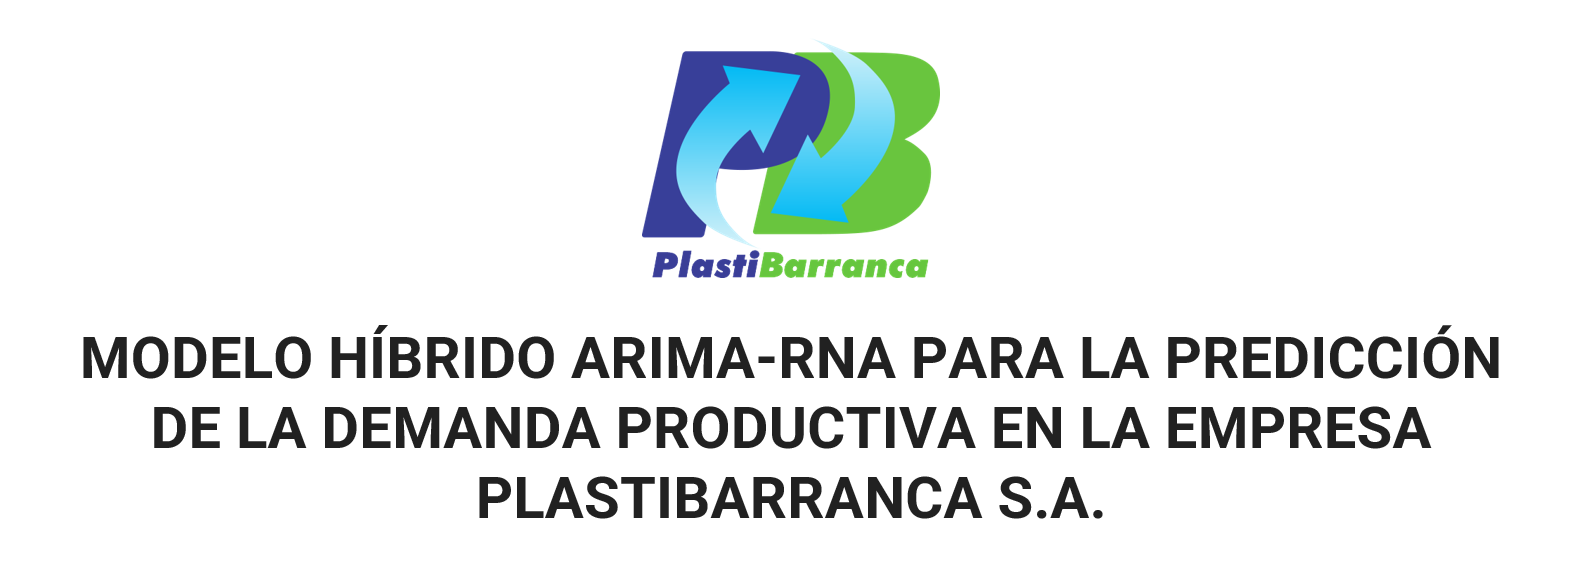

In [ ]:
#@title
Image("/content/drive/MyDrive/Plastibarranca-Miciencias/Ejecucion proyecto/LOGO.png", width=950, height=350)

<p align="justify"> En este notebook reposa el calculo de la demanda de la empresa a partir de los datos historicos que reposan en el sistema de información Merlin del periodo Enero/2020 a Noviembre/2023. El repositorio aborda la construccion y validacion de un modelo de prediccion de la demanda de la empresa utilizado un modelo hibrido compuesto entre el modelo ARIMA y las Redes Neuronales Artificiales (RNA). El modelo ARIMA se integra con el objetivo de capturar la parte lineal asociado al comportamiento de la serie historica. Los residuos del modelo se utilizan para construir la red neuronal y comprende la representacion de la parte no lineal de la misma. La construccion del modelo sigue el flujo expuesto a continuación:

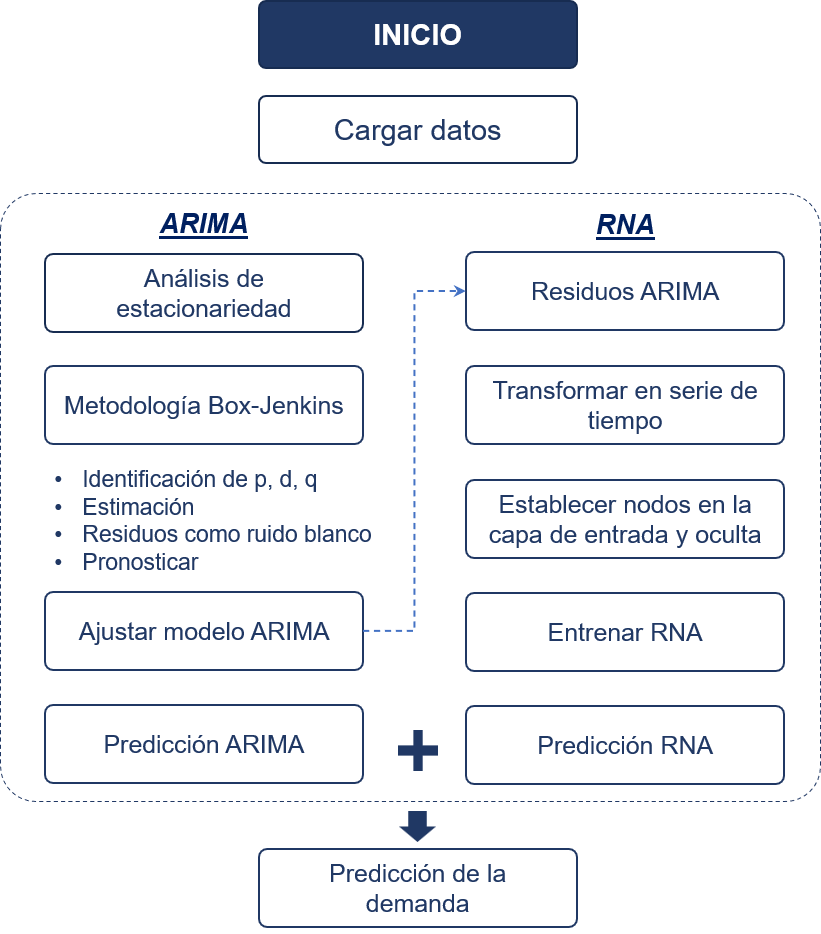

In [ ]:
#@title
Image("/content/drive/MyDrive/Plastibarranca-Miciencias/Ejecucion proyecto/Diagrama.png", width=500, height=650)

In [ ]:
!pip uninstall rpy2 -y!
!pip install rpy2==3.5.1

In [ ]:
# R-studio en Colab
%%capture
%load_ext rpy2.ipython

In [ ]:
%%R
# Paquetes requeridos para ajecutar ejecutar las funciones de R
install.packages("readxl")    # Libreria para la lectura de documentos de excel
install.packages("urca")      # Libreria para aplicar pruebas de estacionariedad (Raiz Unitaria)
install.packages("knitr")     # Libreria para imprimir datos
install.packages("dplyr")     # Libreria para ajustar datos
install.packages("lmtest")    # Libreria para ajustar datos
install.packages("forecast")  # Libreria para analisis de coeficientes
install.packages("WriteXLS")  # Libreria para generar una excel a partir de un dataframe

(as ‘lib’ is unspecified)







	‘/tmp/RtmpykUmMK/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpykUmMK/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpykUmMK/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpykUmMK/downloaded_packages’

(as ‘lib’ is unspecified)














	‘/tmp/RtmpykUmMK/downloaded_packages’

(as ‘lib’ is unspecified)






















































	‘/tmp/RtmpykUmMK/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpykUmMK/downloaded_packages’



In [ ]:
%%R
library(readxl)
library(urca)
library(knitr)
library(dplyr)
library(lmtest)
library(forecast)
library(WriteXLS)

Attaching package: ‘dplyr’



    filter, lag



    intersect, setdiff, setequal, union



Attaching package: ‘zoo’



    as.Date, as.Date.numeric


  method            from
  as.zoo.data.frame zoo 



In [ ]:
%%R library(WriteXLS)

In [ ]:
# Python libraries
from IPython.display import Image

Cargamos la demanda de la empresa en el periodo 2020-2023.

In [ ]:
%%R
# Cargando Demanda dataframe
Data=read_excel("/content/DEMANDA.xlsx")

In [ ]:
%%R
Datamsubsets<-split(Data[,2], rep(1:ceiling(437), each=437, length.out=1311)) # Rangos de datos

trend <- list() # Lista para guardar los resultados de la RU con tendencia y con deriva
drift <- list() # Lista para guardar los resultados de la RU sin tendencia y con deriva
none <- list()  # Lista para guardar los resultados de la RU sin tendencia y sin deriva
pp <- list()    # Lista para guardar los resultados de la prueba PP
URtests<-data.frame(matrix(0, 3, 5)) # Tabla que resume los resultados de la prueba unitaria

# Renombrando cada columna del dataframe
names(URtests)[1]<-paste("Data subsets")
names(URtests)[2]<-paste("Dickey-Fuller test")
names(URtests)[3]<-paste("Dickey-Fuller test - no trend")
names(URtests)[4]<-paste("Dickey-Fuller test- no trend and no drift")
names(URtests)[5]<-paste("Phillips-Perron test")

# Bucle para calcular los tests and cada rango de datos
for (i in 1:3) {

  # Augmented Dickey-Fuller test
  trend[[i]]<-summary(ur.df(ts(Datamsubsets[[i]]), type="trend", selectlags = "AIC"))
  drift[[i]]<-summary(ur.df(ts(Datamsubsets[[i]]), type="drift", selectlags = "AIC"))
  none[[i]]<-summary(ur.df(ts(Datamsubsets[[i]]), type="none", selectlags = "AIC"))
  pp[[i]]<-PP.test(ts(Datamsubsets[[i]]), lshort = "FALSE")

  # Guardando p valores
  URtests[i,2]<-round(trend[[i]]@testreg$coefficients[13],4) # p valor
  URtests[i,3]<-round(drift[[i]]@testreg$coefficients[10],4) # p valor
  URtests[i,4]<-round(none[[i]]@testreg$coefficients[7],4)    # p valor
  URtests[i,5]<-round(pp[[i]][["p.value"]],4)                  # p valor
  URtests[i,1]<-paste("Range", i, "(",((i-1)*437)+1, "-", i*437, ")")
}
kable(URtests)



|Data subsets           | Dickey-Fuller test| Dickey-Fuller test - no trend| Dickey-Fuller test- no trend and no drift| Phillips-Perron test|
|:----------------------|------------------:|-----------------------------:|-----------------------------------------:|--------------------:|
|Range 1 ( 1 - 437 )    |                  0|                             0|                                    0.0152|                 0.01|
|Range 2 ( 438 - 874 )  |                  0|                             0|                                    0.0297|                 0.01|
|Range 3 ( 875 - 1311 ) |                  0|                             0|                                    0.0786|                 0.01|


<p align="justify"> A partir de los resultados de las pruebas unitarias podemos establecer que los datos asociados a la demanda en el periodo Enero de 2020 y Noviembre de 2023 no poseen comportamientos de raiz unitaria en ninguno de los 3 rangos en los que se segmento la serie, ni aplicando las 4 pruebas.

In [ ]:
%%R
Datam<-Data[,2]

In [ ]:
%%R
AIC<- data.frame(matrix(0, 100, 4)) # Matriz que guarda los critrios AIC de cada modelo
colnames(AIC)<-c("p", "d", "q", "AIC") # Nombrando las columnas del dataframe
order<-matrix(0, 1 ,3) # Matriz para guardar el orden de los modelos
k<-1

# Bucle doble para construis los diferentes modelos ARIMA considerando cada combinacion posible de parametros p y q
for (i in 0:9) {
  for (j in 0:9) {
    arm<-arima(Data[,2], order = c(i,0,j), include.mean = FALSE)
    AIC[k,1]<-i
    AIC[k,3]<-j
    AIC[k,4]<-arm$aic # Guardando el AIC de cada modelo
    k<-k+1
  }
}

In [ ]:
%%R
# Mojores modelos de acuerdo al criterio AIC
ca<-AIC
order<-arrange(ca, ca$AIC) # Ordenanado modelos de acuerdo al AIC
order

    p d q      AIC
1   8 0 7 21361.42
2   9 0 8 21361.68
3   7 0 8 21362.38
4   6 0 7 21363.06
5   8 0 9 21363.63
6   8 0 8 21363.66
7   7 0 9 21364.75
8   7 0 7 21364.93
9   9 0 9 21364.98
10  5 0 7 21365.98
11  6 0 8 21366.89
12  6 0 9 21368.33
13  9 0 7 21372.02
14  8 0 6 21376.96
15  5 0 9 21377.86
16  4 0 9 21380.33
17  5 0 8 21382.89
18  8 0 5 21387.63
19  9 0 1 21389.43
20  8 0 2 21391.37
21  8 0 4 21391.72
22  7 0 3 21392.60
23  8 0 3 21393.17
24  9 0 5 21393.26
25  9 0 4 21395.61
26  6 0 5 21397.48
27  7 0 6 21399.03
28  5 0 6 21401.16
29  5 0 5 21403.63
30  5 0 4 21404.41
31  6 0 6 21408.76
32  9 0 6 21413.29
33  1 0 8 21422.41
34  4 0 4 21424.03
35  2 0 9 21424.25
36  1 0 9 21424.32
37  2 0 8 21424.35
38  3 0 9 21425.81
39  3 0 8 21427.31
40  7 0 5 21431.47
41  6 0 4 21432.80
42  6 0 3 21435.11
43  7 0 4 21435.96
44  9 0 3 21442.22
45  1 0 7 21447.64
46  9 0 2 21451.15
47  3 0 6 21453.48
48  7 0 2 21453.98
49  8 0 1 21454.22
50  4 0 7 21455.12
51  3 0 7 21455.16
52  7 0 1 21

In [ ]:
# Modelo ARIMA construido
%%R
modelarm<-arima(Data[,2], order = c(5,order[1,2],7), include.mean = FALSE)
modelarm


Call:
arima(x = Data[, 2], order = c(5, order[1, 2], 7), include.mean = FALSE)

Coefficients:
         ar1      ar2     ar3      ar4     ar5      ma1     ma2      ma3
      1.5691  -1.7923  1.6976  -1.3231  0.8485  -1.2707  1.4376  -1.3179
s.e.  0.0378   0.0875  0.1137   0.0952  0.0456   0.0470  0.0919   0.1150
         ma4      ma5      ma6      ma7
      0.9541  -0.5119  -0.0471  -0.1110
s.e.  0.1031   0.0682   0.0470   0.0311

sigma^2 estimated as 683231:  log likelihood = -10669.99,  aic = 21365.98


In [ ]:
# Significancia del modelo ARIMA
%%R
coeftest(modelarm)


z test of coefficients:

     Estimate Std. Error  z value  Pr(>|z|)    
ar1  1.569143   0.037783  41.5300 < 2.2e-16 ***
ar2 -1.792345   0.087545 -20.4734 < 2.2e-16 ***
ar3  1.697631   0.113692  14.9318 < 2.2e-16 ***
ar4 -1.323064   0.095156 -13.9041 < 2.2e-16 ***
ar5  0.848530   0.045593  18.6108 < 2.2e-16 ***
ma1 -1.270726   0.046975 -27.0509 < 2.2e-16 ***
ma2  1.437626   0.091922  15.6396 < 2.2e-16 ***
ma3 -1.317939   0.115000 -11.4603 < 2.2e-16 ***
ma4  0.954100   0.103108   9.2534 < 2.2e-16 ***
ma5 -0.511860   0.068183  -7.5071 6.043e-14 ***
ma6 -0.047085   0.047023  -1.0013 0.3166808    
ma7 -0.110962   0.031112  -3.5666 0.0003617 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




	Ljung-Box test

data:  Residuals
Q* = 10.939, df = 10, p-value = 0.3623

Model df: 0.   Total lags used: 10



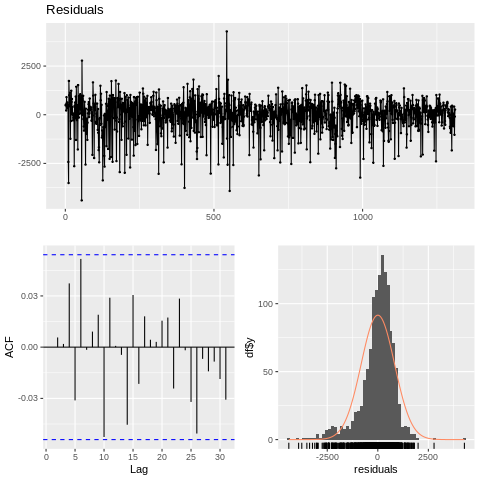

In [ ]:
# Revisando los residuos del modelo ARIMA
%%R
checkresiduals(modelarm$residuals)

<p align="justify"> Se selecciona el modelo ARIMA(5, 0, 7), ya que las primeras nueve alternativas de acuerdo al criterio AIC producen modelos con coeficientes no significativos. En este modelo podemos observar que 11 de 12 parametros son significativos considerando los resultados del test de coeficientes, lo que permite establecer que el modelo construido es pertinente y significativo. Adicionalmente, a partir de la grafica se puede observar que los residuos del modelo no presentan comportamientos correlacionados al no superar las bandas de bartel, es decir que el modelo ARIMA(5, 0, 7) logra capturar adecuadamente el comportamiento de la serie historica.

Ahora para construir la parte relacionada con el modelo RNA se utilizan los residuos obtenidos en el modelo ARIMA.

In [ ]:
%%R
anndata<-(modelarm$residuals)

In [ ]:
%%R
ann<-nnetar(ts(anndata), size=10, repeats=100)

In [ ]:
%%R
prediccion<-data.frame(forecast(modelarm, h=31)$mean+(forecast(ann,h=31)$mean))
prediccion

   forecast.modelarm..h...31..mean....forecast.ann..h...31..mean.
1                                                        3916.869
2                                                        3550.048
3                                                        3752.764
4                                                        3841.106
5                                                        3903.622
6                                                        4179.794
7                                                        4066.443
8                                                        3594.538
9                                                        3523.863
10                                                       3757.743
11                                                       3837.337
12                                                       3953.366
13                                                       4084.601
14                                                       3849.674
15        

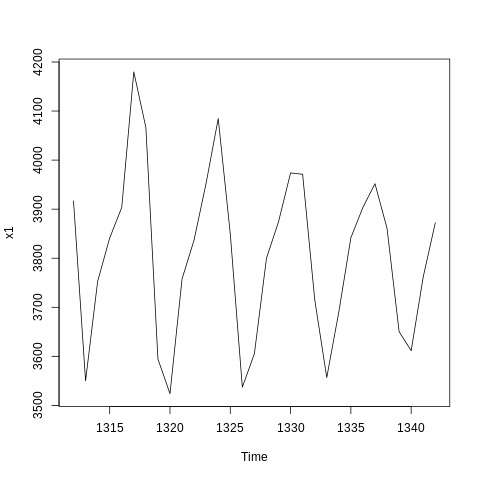

In [ ]:
%%R
plot(prediccion)

In [ ]:
# Guardamos los valores obtenidos
%%R
WriteXLS(prediccion, "PREDICCION.xlsx")

<p align="justify"> Para satisfacer adecuadamente la demanda de los clientes la empresa debe realizar una caracterizacion de los procesos y alinear los esfuerzos para el cumplimiento de los requerimientos exigidos a cada puesto o area de trabajo con base en las restricciones del mismo.